In [62]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from plotly.offline import init_notebook_mode
from yellowbrick.cluster import KElbowVisualizer
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from scipy import stats
from mpl_toolkits import mplot3d
import datetime as dt
sns.set_style("whitegrid")

In [65]:
df = pd.read_excel('../../sales_forecasting/code/online_retail.xlsx')

In [66]:
temp = df

In [58]:
df = temp

In [67]:
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


### Sales Trend

In [7]:
def dates_gen(start, end, df): 
    datesIndex = pd.date_range(start, end, freq='M') 
    datesIndex = datesIndex.tolist()
    df['InvoiceDate'] = pd.to_datetime(df.InvoiceDate)
    df = df.loc[df['InvoiceDate'].between(start, end)]
    return datesIndex, df


In [ ]:
start = '2010-12-01'
end = '2011-05-01'
datesIndex = pd.date_range(start, end, freq='M') 
datesIndex = datesIndex.tolist()
datesIndex

In [5]:
df['InvoiceDate'] = pd.to_datetime(df.InvoiceDate)
df = df.loc[df['InvoiceDate'].between(start, end)]
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


In [6]:
general_trend = pd.DataFrame(data={'Date':pd.to_datetime(df.InvoiceDate).dt.date,
                                  'Total price':df.Quantity*df.UnitPrice})
general_trend = general_trend.groupby("Date")["Total price"].sum()
general_trend = pd.DataFrame(general_trend)

In [7]:
general_trend.head()

,Total price
Date,
2010-12-01,58635.56
2010-12-02,46207.28
2010-12-03,45620.46
2010-12-05,31383.95
2010-12-06,53860.18


In [8]:
rolling_days = general_trend.copy()
rolling_days['Total price'] = rolling_days["Total price"].rolling(window=30).mean() 
# rolling_days.drop(['Total price'], axis=1, inplace=True)

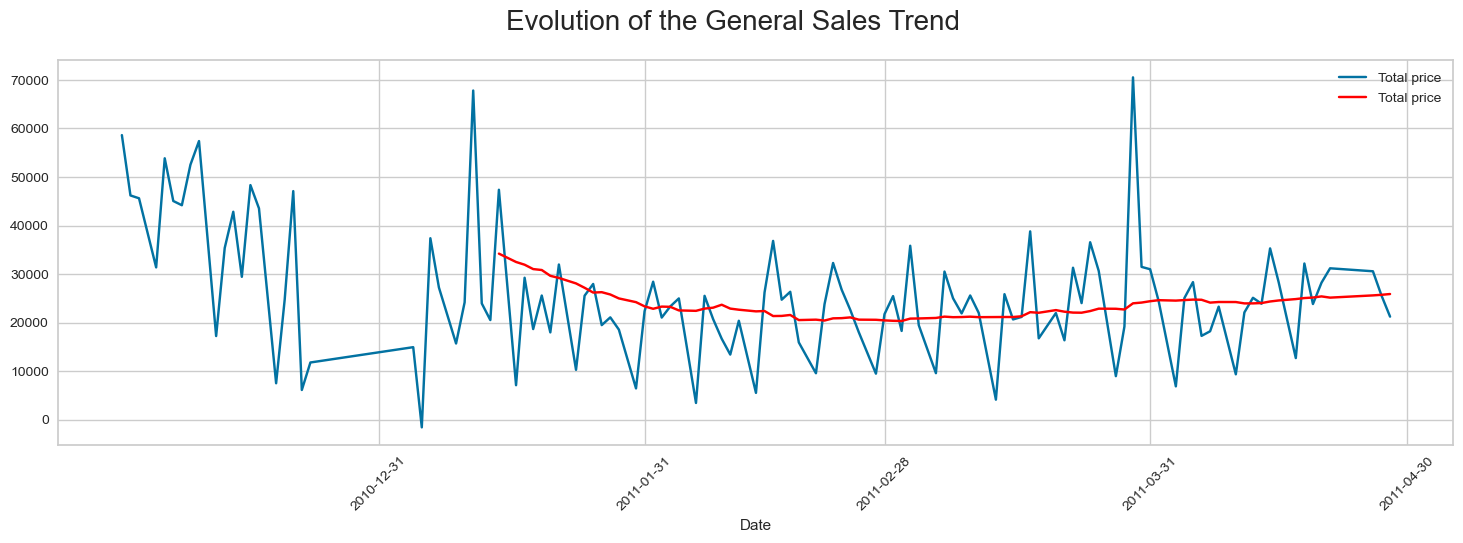

In [9]:
plt.figure(figsize = (18,5)).suptitle('Evolution of the General Sales Trend', fontsize=20)
sns.lineplot(data=general_trend)
sns.lineplot(data=rolling_days, palette=['red'])
plt.xticks(datesIndex, rotation = 45)
plt.show()

In [39]:
start = '2011-01-01'
end = '2011-11-01'
# datesIndex = pd.date_range(start, end, freq='M') 
# # datesIndex = datesIndex.tolist()
# general_trend.index = pd.to_datetime(general_trend.index)
# general_trend_months = general_trend.groupby([general_trend.index.year,general_trend.index.month])['Total price'].sum()
# general_trend_months = pd.DataFrame(general_trend_months)
# general_trend_months["Date"] = datesIndex

### Customers each month

In [40]:
datesIndex, df = dates_gen(start, end, df)
number_customers = df.groupby(df["InvoiceDate"].dt.to_period('M'))["CustomerID"].nunique()
number_customers = pd.DataFrame(data=number_customers).reset_index()
number_customers["Date"] = number_customers.InvoiceDate.dt.to_timestamp()

number_new_customers = []
customers_seen = []
for month in df["InvoiceDate"].dt.to_period('M').unique():
    customers = df[df["InvoiceDate"].dt.to_period('M') == month].CustomerID.unique()
    count=0
    for customer in customers:
        if customer not in customers_seen:
            count+=1
            customers_seen.append(customer)
    number_new_customers.append((month,count))
number_new_customers = pd.DataFrame(number_new_customers,columns=["Date","New customers"])
number_new_customers.Date = number_new_customers.Date.dt.to_timestamp()

In [41]:
number_new_customers

,Date,New customers
0,2011-01-01,784
1,2011-02-01,500
2,2011-03-01,531
3,2011-04-01,361
4,2011-05-01,318
5,2011-06-01,264
6,2011-07-01,219
7,2011-08-01,185
8,2011-09-01,314
9,2011-10-01,372


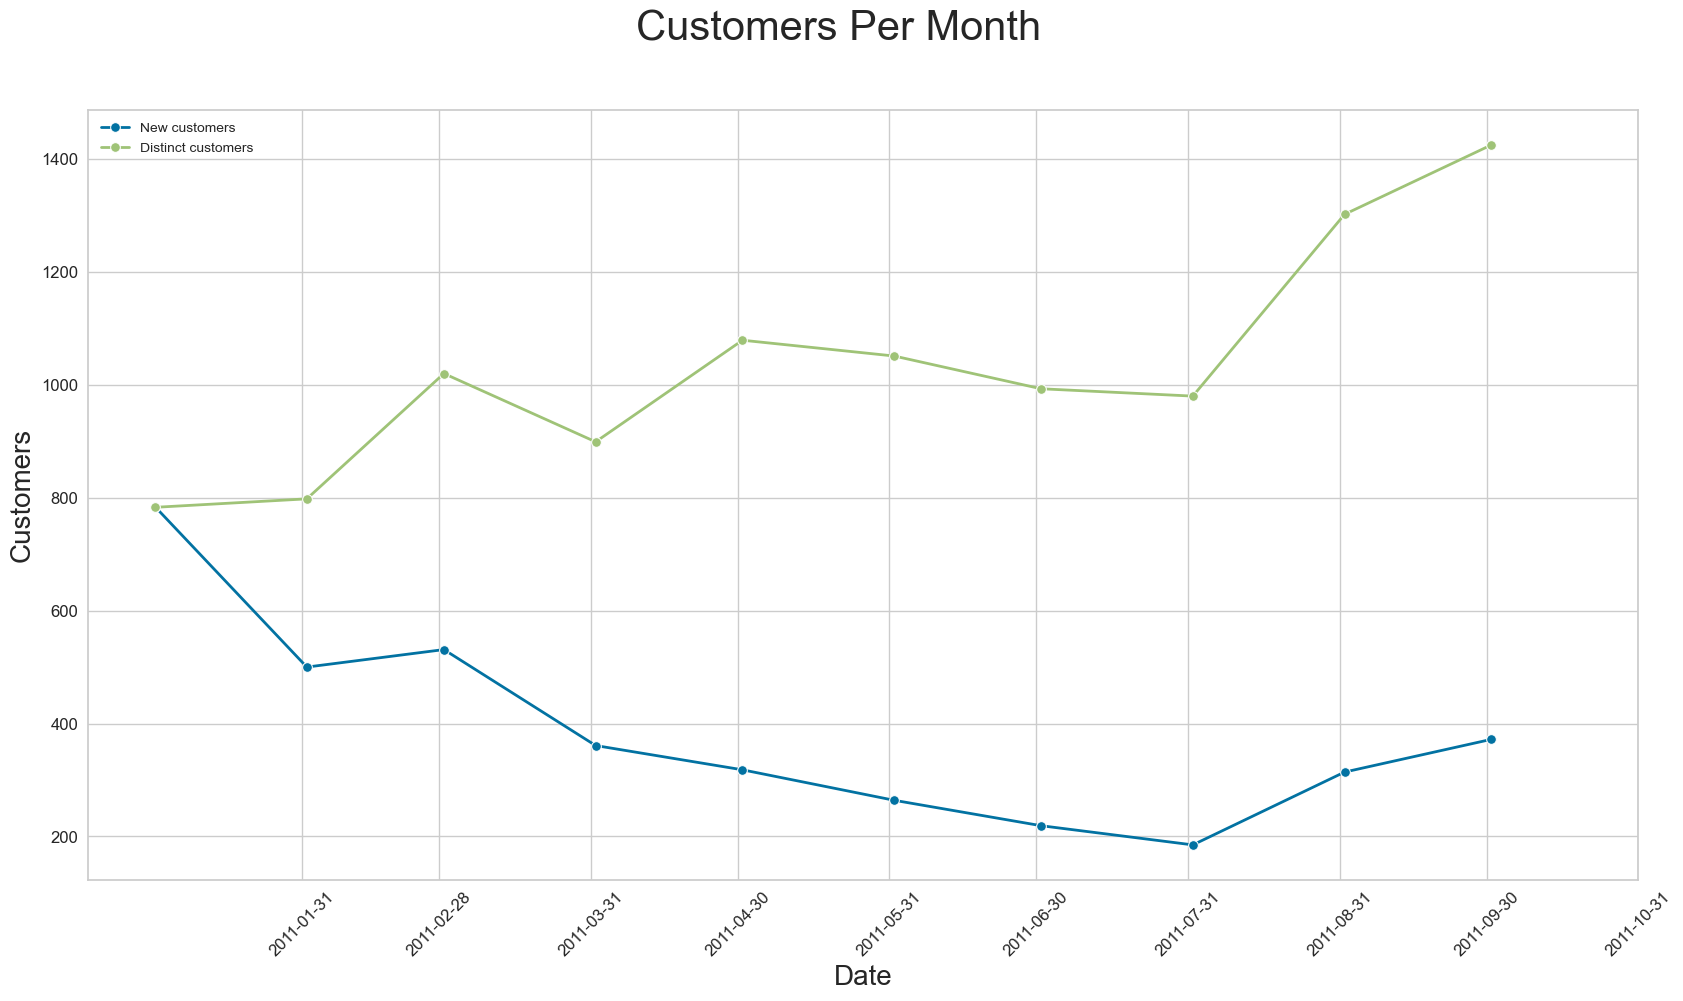

In [42]:
fig  = plt.figure(figsize = (20,10)).suptitle('Customers Per Month', fontsize=30)
lineplot = sns.lineplot(data=number_new_customers,x="Date", y="New customers", marker="o",linewidth = 2, label="New customers")
sns.lineplot(data=number_customers,x="Date", y="CustomerID", marker="o",linewidth = 2, label="Distinct customers")

lineplot.set_xlabel("Date",fontsize=20)
lineplot.set_ylabel("Customers",fontsize=20)
plt.xticks(datesIndex,rotation = 45,fontsize=12)
plt.yticks(fontsize=12)
plt.show()

### Time of the day

In [68]:
def daytime_encoder(date):
    if (date.hour >= 5)&(date.hour < 8):
        return "Early morning"
    elif (date.hour >= 8)&(date.hour < 11):
        return "Morning"
    elif (date.hour >= 11)&(date.hour < 13):
        return "Late morning"
    elif (date.hour >= 13)&(date.hour < 14):
        return "Early afternoon"
    elif (date.hour >= 14)&(date.hour < 15):
        return "Afternoon"
    elif (date.hour >= 15)&(date.hour < 17):
        return "Late afternoon"
    elif (date.hour >= 17)&(date.hour < 21):
        return "Evening"
    else:
        return date.hour

df['InvoiceDate'] = df['InvoiceDate'].map(daytime_encoder)
# df['daytime'] = pd.DataFrame(["Night","Early morning","Morning","Late morning","Early afternoon","Afternoon","Late afternoon","Evening"])


In [70]:
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,Morning,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,Morning,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,Morning,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,Morning,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,Morning,3.39,17850.0,United Kingdom


In [73]:
group = df.InvoiceDate.groupby(['InvoiceDate']).count()

df_daytime['daytime'] = group['InvoiceDate']
df_daytime['transaction'] = group['InvoinceNo']
df

,InvoiceNo,StockCode,Description,Quantity,UnitPrice,CustomerID,Country
InvoiceDate,,,,,,,
Afternoon,67471,67471,67260,67471,67471,55075,67471
Early afternoon,72259,72259,72136,72259,72259,65062,72259
Early morning,424,424,424,424,424,424,424
Evening,41059,41059,40877,41059,41059,21253,41059
Late afternoon,132035,132035,131631,132035,132035,71217,132035
Late morning,136383,136383,136062,136383,136383,123591,136383
Morning,92278,92278,92065,92278,92278,70207,92278


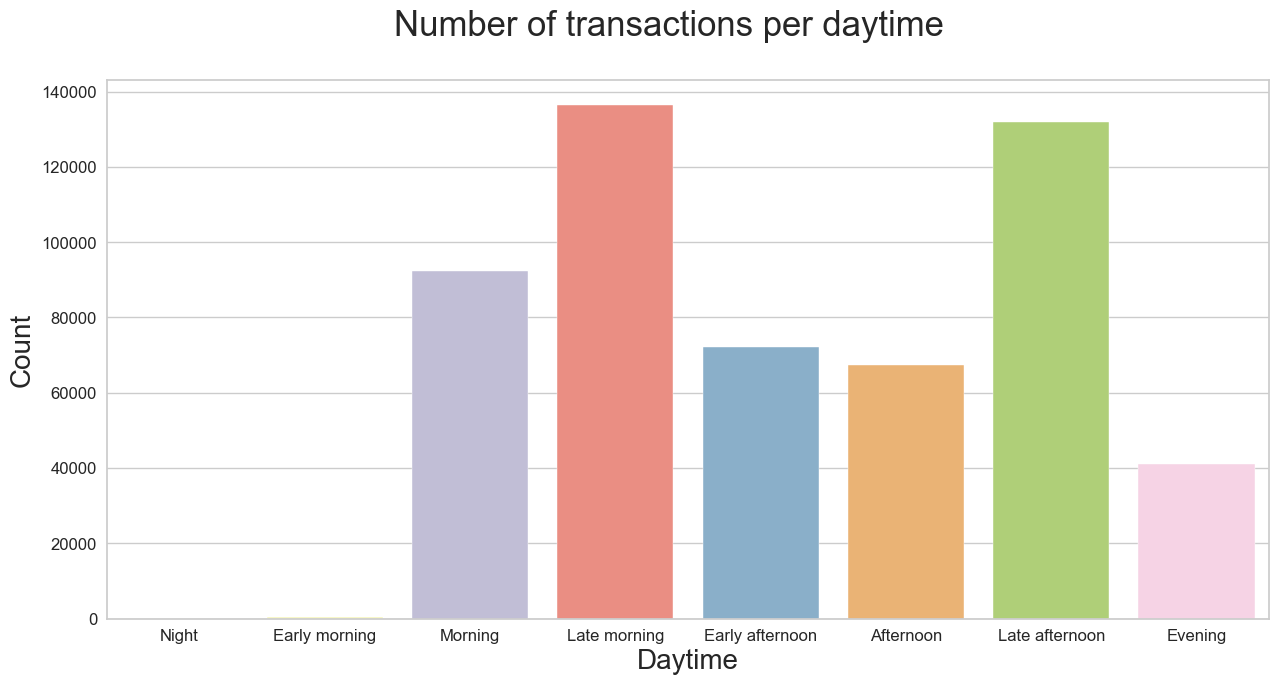

In [46]:
fig  = plt.figure(figsize = (15,7)).suptitle('Number of transactions per daytime', fontsize=25)
countplot = sns.countplot(data=df,x="InvoiceDate",order = ["Night","Early morning","Morning","Late morning","Early afternoon","Afternoon","Late afternoon","Evening"], palette="Set3")

countplot.set_xlabel("Daytime",fontsize=20)
countplot.set_ylabel("Count",fontsize=20)
plt.xticks(size=12)
plt.yticks(size=12)
plt.show()

In [56]:
df

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,dayTime
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,Morning,2.55,17850.0,United Kingdom,Night
1,536365,71053,WHITE METAL LANTERN,6,Morning,3.39,17850.0,United Kingdom,Early morning
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,Morning,2.75,17850.0,United Kingdom,Morning
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,Morning,3.39,17850.0,United Kingdom,Late morning
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,Morning,3.39,17850.0,United Kingdom,Early afternoon
...,...,...,...,...,...,...,...,...,...
541904,581587,22613,PACK OF 20 SPACEBOY NAPKINS,12,Late morning,0.85,12680.0,France,NaN
541905,581587,22899,CHILDREN'S APRON DOLLY GIRL,6,Late morning,2.10,12680.0,France,NaN
541906,581587,23254,CHILDRENS CUTLERY DOLLY GIRL,4,Late morning,4.15,12680.0,France,NaN
541907,581587,23255,CHILDRENS CUTLERY CIRCUS PARADE,4,Late morning,4.15,12680.0,France,NaN
